### Downloading data

In [ ]:
!mkdir -p ~/.kaggle
!wget -O ~/.kaggle/kaggle.json "https://drive.google.com/uc?export=download&id=1eN1kfpt1EQS-KQk-A9M2hWO-uhEBMwE0"
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download 'child-mind-institute-detect-sleep-states'
!mkdir -p data
!unzip -qqn child-mind-institute-detect-sleep-states.zip -d data

### Reading event data

In [1]:
from os import path
import gc
import pyarrow as pa
import pyarrow.parquet
import pandas as pd
import numpy as np

In [2]:
data_root = 'data_reduced'

In [3]:
train_events = pd.read_csv(
    path.join(data_root, 'train_events.csv'),
    dtype={
        'series_id': 'str',
        'night': 'Int32',
        'event': 'str',
        'step': 'Int64',
    }
)
series_list = train_events['series_id'].unique()
n_series = len(series_list)
print(series_list[:10])
print(n_series)

['038441c925bb' '03d92c9f6f8a' '0402a003dae9' '04f547b8017d'
 '05e1944c3818' '062cae666e2a' '062dbd4c95e6' '08db4255286f'
 '0a96f4993bd7' '0cd1e3d0ed95']
10


### Cleaning event data

Drop events without time information.

In [4]:
train_events = train_events.dropna(axis=0)
train_events.info()

<class 'pandas.core.frame.DataFrame'>
Index: 272 entries, 0 to 503
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   series_id  272 non-null    object
 1   night      272 non-null    Int32 
 2   event      272 non-null    object
 3   step       272 non-null    Int64 
 4   timestamp  272 non-null    object
dtypes: Int32(1), Int64(1), object(3)
memory usage: 12.2+ KB


In [5]:
bad_nights = train_events[['series_id', 'night', 'event']].groupby(by=['series_id', 'night']).count()
bad_nights = bad_nights[bad_nights['event']!=2].reset_index()
print(bad_nights)

Empty DataFrame
Columns: [series_id, night, event]
Index: []


In [6]:
bad_series = bad_nights['series_id'].unique()

In [7]:
print(bad_series)

[]


In [8]:
train_events = train_events[~(train_events['series_id'].isin(bad_series))]

In [9]:
series_list = train_events['series_id'].unique()
print(series_list[:10])
print(len(series_list))

['038441c925bb' '03d92c9f6f8a' '0402a003dae9' '04f547b8017d'
 '05e1944c3818' '062cae666e2a' '062dbd4c95e6' '08db4255286f'
 '0a96f4993bd7' '0cd1e3d0ed95']
10


### Reading time series data

In [10]:
series_schema = pa.schema([
    ('series_id', pa.string()),
    ('step', pa.uint32()),
    ('timestamp', pa.timestamp('s', tz='UTC')),
    ('anglez', pa.float32()),
    ('enmo', pa.float32())
])

train_series = pyarrow.parquet.read_table(
    path.join(data_root, 'train_series.parquet'),
    schema=series_schema
)

display(train_series)

pyarrow.Table
series_id: string
step: uint32
timestamp: timestamp[s, tz=UTC]
anglez: float
enmo: float
----
series_id: [["038441c925bb","038441c925bb","038441c925bb","038441c925bb","038441c925bb",...,"038441c925bb","038441c925bb","038441c925bb","038441c925bb","038441c925bb"],["038441c925bb","038441c925bb","038441c925bb","038441c925bb","038441c925bb",...,"038441c925bb","038441c925bb","038441c925bb","038441c925bb","038441c925bb"],...,["0cd1e3d0ed95","0cd1e3d0ed95","0cd1e3d0ed95","0cd1e3d0ed95","0cd1e3d0ed95",...,"0cd1e3d0ed95","0cd1e3d0ed95","0cd1e3d0ed95","0cd1e3d0ed95","0cd1e3d0ed95"],["0cd1e3d0ed95","0cd1e3d0ed95","0cd1e3d0ed95","0cd1e3d0ed95","0cd1e3d0ed95",...,"0cd1e3d0ed95","0cd1e3d0ed95","0cd1e3d0ed95","0cd1e3d0ed95","0cd1e3d0ed95"]]
step: [[0,1,2,3,4,...,131067,131068,131069,131070,131071],[131072,131073,131074,131075,131076,...,262139,262140,262141,262142,262143],...,[119560,119561,119562,119563,119564,...,250627,250628,250629,250630,250631],[250632,250633,250634,250635,250636,.

In [11]:
train_series: pd.DataFrame = train_series.to_pandas()

### Standardization

In [12]:
from sklearn.preprocessing import StandardScaler

In [16]:
train_series.describe()

,step,anglez,enmo
count,4.838220e+06,4.838220e+06,4.838220e+06
mean,2.687330e+05,-6.369770e+00,3.482787e-02
std,1.835197e+05,3.526616e+01,8.127654e-02
min,0.000000e+00,-9.000000e+01,0.000000e+00
25%,1.209550e+05,-2.811710e+01,1.100000e-03
50%,2.419105e+05,-6.274550e+00,1.410000e-02
75%,3.751930e+05,1.436060e+01,3.940000e-02
max,7.786790e+05,8.965560e+01,4.854500e+00


In [17]:
display(train_series)

,series_id,step,timestamp,anglez,enmo
0,038441c925bb,0,2018-08-14 19:30:00+00:00,2.636700,0.0217
1,038441c925bb,1,2018-08-14 19:30:05+00:00,2.636800,0.0215
2,038441c925bb,2,2018-08-14 19:30:10+00:00,2.637000,0.0216
3,038441c925bb,3,2018-08-14 19:30:15+00:00,2.636800,0.0213
4,038441c925bb,4,2018-08-14 19:30:20+00:00,2.636800,0.0215
...,...,...,...,...,...
4838215,0cd1e3d0ed95,370255,2017-12-30 06:14:35+00:00,11.444400,0.0152
4838216,0cd1e3d0ed95,370256,2017-12-30 06:14:40+00:00,11.441600,0.0153
4838217,0cd1e3d0ed95,370257,2017-12-30 06:14:45+00:00,11.463000,0.0153
4838218,0cd1e3d0ed95,370258,2017-12-30 06:14:50+00:00,11.476700,0.0152


In [18]:
train_series = train_series.drop(columns=['timestamp', 'step'])

In [19]:
scaler = StandardScaler()

train_series[['anglez', 'enmo']] = scaler.fit_transform(train_series[['anglez', 'enmo']])

In [20]:
train_series.describe()

,anglez,enmo
count,4.838220e+06,4.838220e+06
mean,2.456181e-08,2.478889e-08
std,1.000000e+00,1.000000e+00
min,-2.371403e+00,-4.285108e-01
25%,-6.166630e-01,-4.149768e-01
50%,2.699999e-03,-2.550291e-01
75%,5.878263e-01,5.625391e-02
max,2.722876e+00,5.929967e+01


In [21]:
display(train_series)

,series_id,anglez,enmo
0,038441c925bb,0.255386,-0.161521
1,038441c925bb,0.255388,-0.163982
2,038441c925bb,0.255394,-0.162751
3,038441c925bb,0.255388,-0.166443
4,038441c925bb,0.255388,-0.163982
...,...,...,...
4838215,0cd1e3d0ed95,0.505135,-0.241495
4838216,0cd1e3d0ed95,0.505056,-0.240265
4838217,0cd1e3d0ed95,0.505663,-0.240265
4838218,0cd1e3d0ed95,0.506051,-0.241495


In [22]:
gc.collect()

788

### Sampling data

In [27]:
import random
import matplotlib.pyplot as plt

In [40]:
frame_size = 30 * 12 # frame width
min_none_sample_interval = 2 * 60 * 12 # minimum steps between events to sample none frames from
none_padding = 30 * 12 # padding between events and none frames
event_sample_margin = 9 * 12 # event margin to frame edges
event_sample_stride = 2 * 12 # event sampling stride

In [41]:
# Extracts samples between two events
def sample_between(start, end, n_samples, padding=none_padding) -> list[tuple[int]]:
    samples = []
    gap = (end - start - 2 * padding - n_samples * frame_size) // (n_samples - 1)
    stride = gap + frame_size
    for frame_start in range(start + padding, end - frame_size - padding + 1, stride):
        samples.append((frame_start, frame_start+frame_size))
    return samples

In [42]:
# Extracts samples around an event
def sample_around(event, margin, stride) -> list[list]:
    samples = []
    for frame_start in range(event - frame_size + margin + 1, event - margin + 1, stride):
        samples.append((frame_start, frame_start + frame_size))
    return samples

In [43]:
event_map = {}
for series_id, events in train_events.groupby('series_id'):
    event_map[series_id] = events.drop(columns=['series_id', 'timestamp']).reset_index(drop=True)

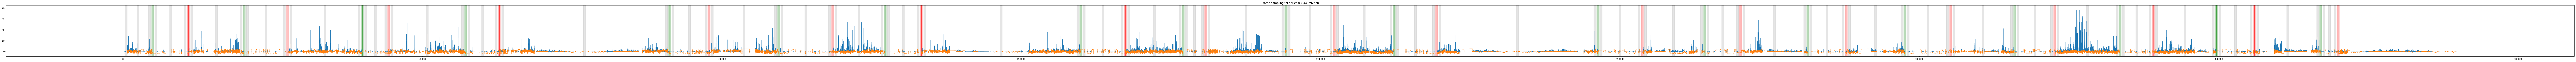

In [45]:
def display_sampling(series_id):
    series = train_series[train_series['series_id'] == series_id].reset_index()
    events = event_map[series_id]
    series = series.reset_index()[['enmo', 'anglez']].to_numpy()
    plt.figure(figsize=(200, 4))
    plt.title(f'Frame sampling for series {series_id}')

    last_event_step = 0
    for i in range(len(events)):
        step = events['step'][i]
        type = events['event'][i]

        event_color = 'green' if type == 'onset' else 'red'
        plt.axvline(step, color=event_color, lw=0.5)
        
        event_samples = sample_around(step, event_sample_margin, event_sample_stride)
        for frame_start, frame_end in event_samples:
            plt.axvspan(frame_start, frame_end, color=event_color, alpha=0.05)

        if step - last_event_step >= min_none_sample_interval:
            n_samples = len(event_samples) // 2
            for frame_start, frame_end in sample_between(last_event_step, step, n_samples):
                plt.axvspan(frame_start, frame_end, color='black', alpha=0.1)
        last_event_step = step
    plt.plot(series, lw=0.5)

display_sampling(series_list[0])

In [46]:
X_none = []
X_onset = []
X_onset_time = []
X_wakeup = []
X_wakeup_time = []

grouped = train_series.groupby('series_id')
for series_id, s in grouped:
    series = s.reset_index()[['enmo', 'anglez']].to_numpy()
    events = event_map[series_id]

    last_event_step = 0
    for i in range(len(events)):
        step = events['step'][i]
        type = events['event'][i]
        
        event_samples = sample_around(step, event_sample_margin, event_sample_stride)
        for frame_start, frame_end in event_samples:
            if type == 'onset':
                X_onset.append(series[frame_start:frame_end])
                X_onset_time.append(step - frame_start)
            if type == 'wakeup':
                X_wakeup.append(series[frame_start:frame_end])
                X_wakeup_time.append(step - frame_start)
        if step - last_event_step >= min_none_sample_interval:
            n_samples = len(event_samples) // 2
            for frame_start, frame_end in sample_between(last_event_step, step, n_samples):
                X_none.append(series[frame_start:frame_end])
        last_event_step = step

In [47]:
print(len(X_none))
print(len(X_onset))
print(len(X_wakeup))

816
816
816


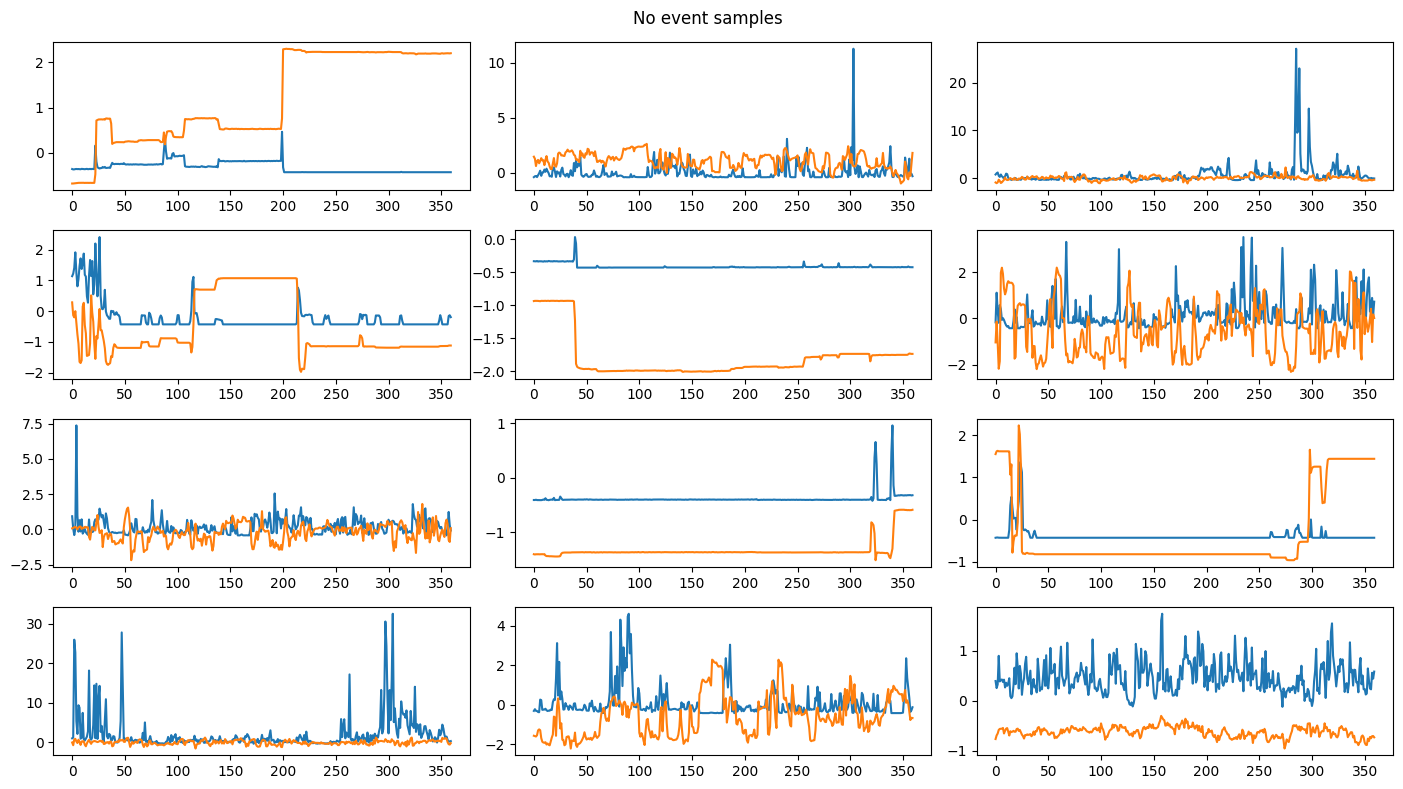

In [48]:
def plot_none_samples(samples):
    cols = 3
    rows = 4
    fig, ax = plt.subplots(rows, cols, figsize=(14, 8))
    for i in range(rows):
        for j in range(cols):
            ax[i][j].plot(samples[j * rows + i])
    plt.suptitle('No event samples')
    plt.tight_layout()
    plt.show()

plot_none_samples(random.sample(X_none, 12))

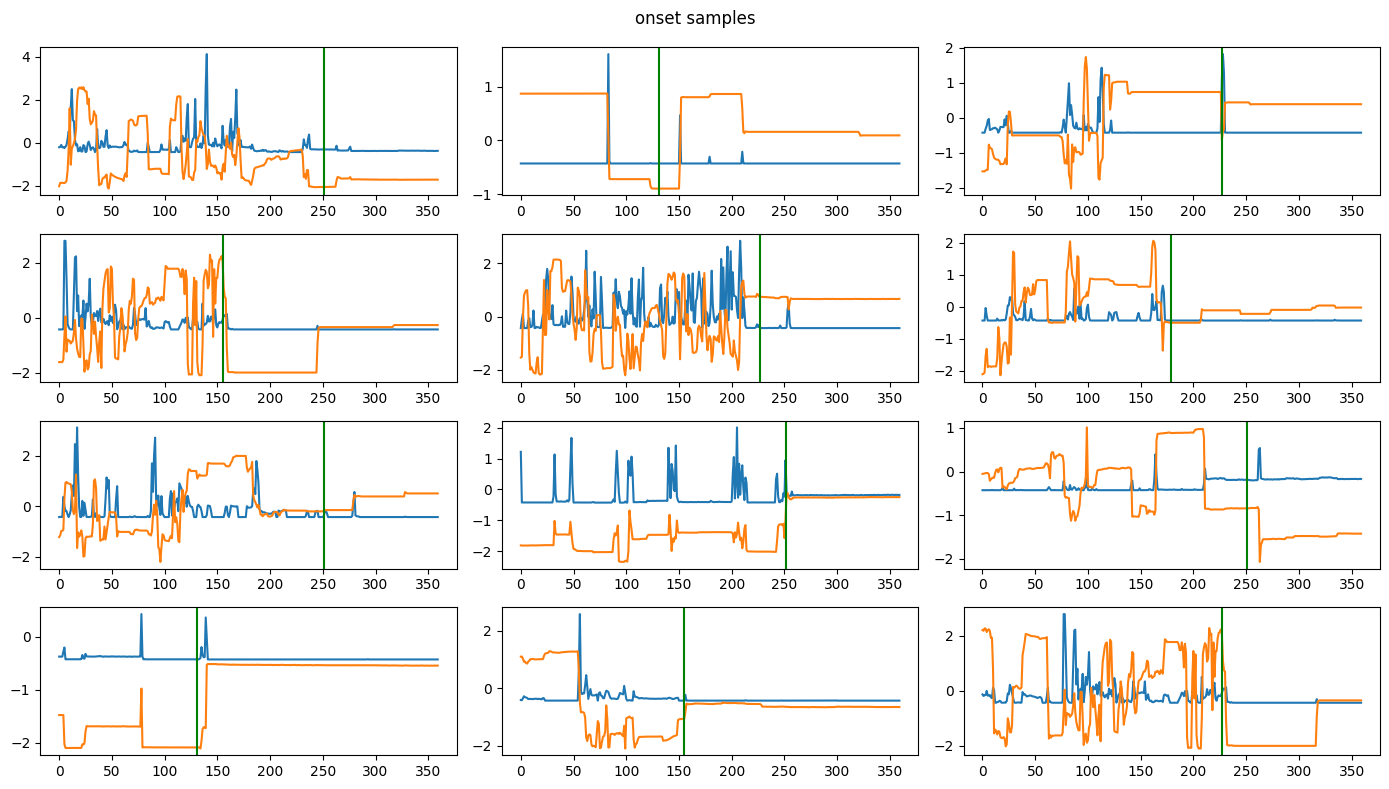

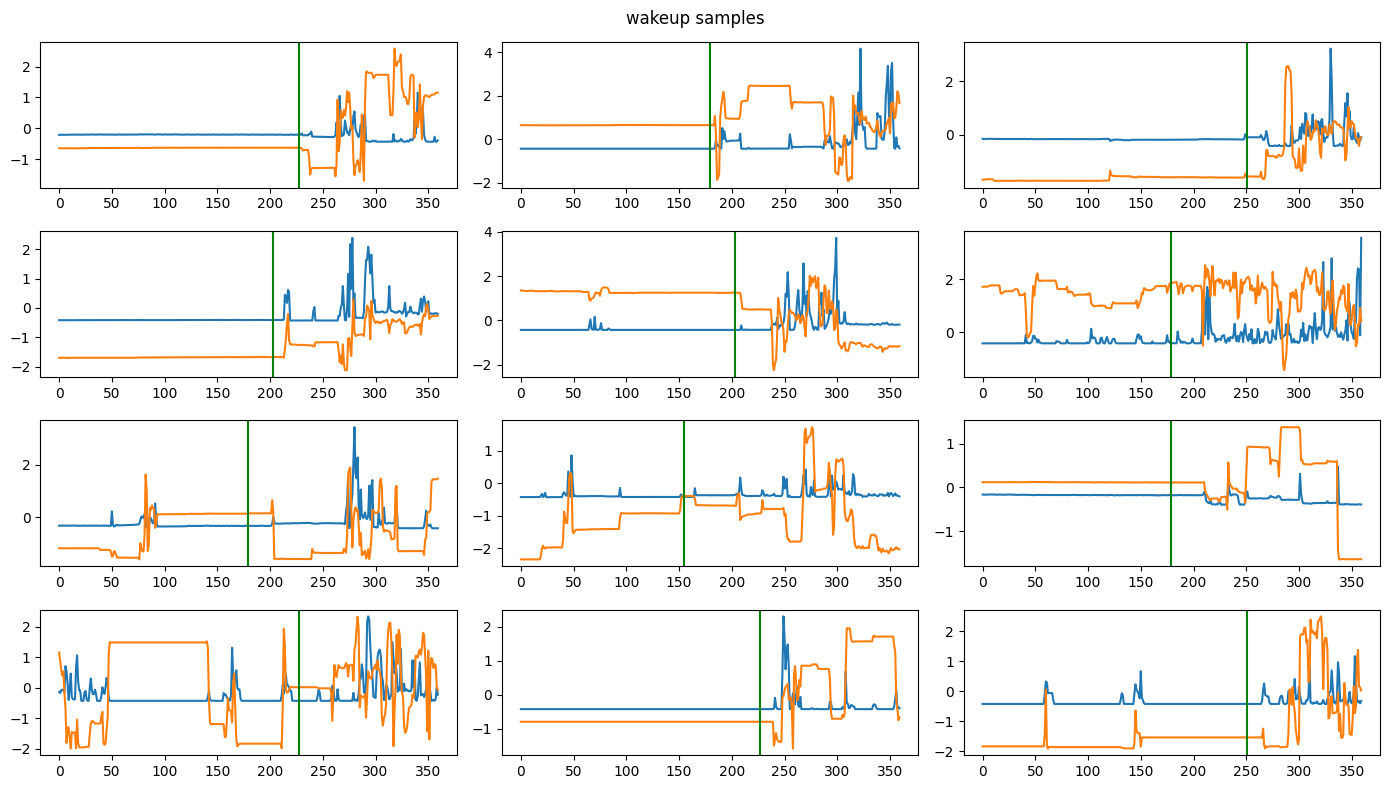

In [49]:
def plot_event_samples(type, samples: list[tuple]):
    cols = 3
    rows = 4
    _, ax = plt.subplots(rows, cols, figsize=(14, 8))
    for i in range(rows):
        for j in range(cols):
            sample = samples[j * rows + i]
            ax[i][j].plot(sample[0])
            ax[i][j].axvline(sample[1], c='green')
    plt.suptitle(f'{type} samples')
    plt.tight_layout()
    plt.show()

plot_event_samples('onset', random.sample(list(zip(X_onset, X_onset_time)), 12))
plot_event_samples('wakeup', random.sample(list(zip(X_wakeup, X_wakeup_time)), 12))

### Assembling the dataset

In [50]:
n_samples = len(X_none) + len(X_onset) + len(X_wakeup)
n_features = 2

X = np.empty([n_samples, frame_size, n_features], dtype=np.float32) # input
Y = np.empty([n_samples, 1], dtype=np.int8) # labels

idx = 0

def fill_data(x, y):
    global idx
    n = len(x)
    X[idx:idx + n] = x
    Y[idx:idx + n] = y
    idx += n

fill_data(X_none, 0)
fill_data(X_onset, 1)
fill_data(X_wakeup, 2)

In [51]:
print(X.shape)
print(Y.shape)

(2448, 360, 2)
(2448, 1)
